# Análise de Sentimento Financeiro

Neste notebook, buscamos entender o sentimento financeiro por meio de análises de sentimentos em textos. O objetivo é classificar os sentimentos expressos em textos financeiros como positivos, negativos ou neutros.

Essa tarefa se faz necessária devido à crescente quantidade de dados financeiros disponíveis, como notícias, relatórios e comentários de analistas. A análise de sentimentos pode ajudar investidores e analistas a tomar decisões informadas com base nas emoções expressas nesses textos. É uma ferramenta diretamente aplicável ao feedback de clientes, relatórios financeiros e até mesmo em redes sociais, onde as opiniões sobre ações e mercados podem influenciar o comportamento do mercado.


In [15]:
# Importar bibliotecas necessárias
import re

# Manipulação de Dados e Análise
import pandas as pd
import numpy as np
from collections import Counter

import xgboost
from scipy import stats

# Visualização
from matplotlib import pyplot as plt
import seaborn as sns

# Pré-processamento de Texto e NLP (Processamento de Linguagem Natural)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings

from sklearn.dummy import DummyClassifier
# Pré-processamento de Dados e Seleção de Modelos
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn import svm # Importação duplicada, mas mantida caso haja uso específico de 'sklearn.svm' além de 'SVC'
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost # Considerado um modelo de ensemble (Gradient Boosting)

from typing import Dict, List, Set, Tuple, Optional

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

try:
    nltk.wordnet.WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except:
    nltk.download('omw-1.4', quiet=True)


### Carregando os Dados

In [16]:
# Leitura de Dados
try:
    dataset_df = pd.read_csv("../data/data.csv") # Caminho original do notebook
except FileNotFoundError:
    print("Arquivo '../data/data.csv' não encontrado. Tentando 'data.csv' no diretório atual.")
    try:
        dataset_df = pd.read_csv("./data/data.csv") # Tentativa alternativa
    except FileNotFoundError:
        print("ERRO: Arquivo de dados não encontrado. Verifique o caminho.")
        exit()

display(dataset_df.head(5))

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Funções Auxiliares

In [17]:
def load_loughran_mcdonald(file_path: str, categories: List[str] = None) -> Dict[str, Set[str]]:
    """
    Carrega o dicionário Loughran-McDonald de um arquivo CSV.

    Args:
        file_path: Caminho para o arquivo CSV do dicionário LM
        categories: Lista de categorias a serem carregadas

    Returns:
        Dicionário com sets de palavras por categoria
    """
    if categories is None:
        categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious',
                     'Strong_Modal', 'Weak_Modal', 'Constraining']

    lexicons = {cat: set() for cat in categories}

    try:
        df = pd.read_csv(file_path, usecols=['Word'] + categories,
                        keep_default_na=False, na_values=[''])

        for category in categories:
            if category in df.columns:
                numeric_col = pd.to_numeric(df[category], errors='coerce')
                mask = numeric_col.notna() & (numeric_col > 0)
                words = df.loc[mask, 'Word']
                lexicons[category].update(word.upper() for word in words if isinstance(word, str))

        print(f"Dicionário LM carregado: {file_path}")
        for cat, words in lexicons.items():
            print(f"  {cat}: {len(words)} palavras")

    except FileNotFoundError:
        print(f"Arquivo não encontrado: {file_path}")
        print("Continuando com dicionários vazios...")
    except Exception as e:
        print(f"Erro ao carregar dicionário: {e}")

    return lexicons

# =============================================================================
# ENGENHARIA DE FEATURES
# =============================================================================

def tokenize_text(text: str) -> List[str]:
    """Tokeniza texto e converte para maiúsculas (padrão LM)."""
    if pd.isna(text):
        return []
    return [word.upper() for word in re.findall(r'\b\w+\b', str(text))]

def count_lexicon_words(tokens: List[str], word_set: Set[str]) -> int:
    """Conta palavras que estão no conjunto de léxico."""
    return sum(1 for word in tokens if word in word_set)

def calculate_basic_features(df: pd.DataFrame, text_column: str = 'Sentence') -> pd.DataFrame:
    """Calcula features básicas de texto."""
    result = df.copy()

    # Features básicas
    result['text_length'] = result[text_column].str.len().fillna(0)
    result['tokens'] = result[text_column].apply(tokenize_text)
    result['word_count'] = result['tokens'].apply(len)
    result['exclamation_count'] = result[text_column].str.count(r'\!').fillna(0)
    result['question_count'] = result[text_column].str.count(r'\?').fillna(0)
    result['uppercase_ratio'] = result[text_column].apply(
        lambda x: sum(c.isupper() for c in str(x)) / len(str(x)) if len(str(x)) > 0 else 0
    )

    return result

def calculate_lm_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]]) -> pd.DataFrame:
    """Calcula features baseadas no dicionário Loughran-McDonald."""
    result = df.copy()

    # Features LM
    result['lm_positive'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Positive', set()))
    )
    result['lm_negative'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Negative', set()))
    )
    result['lm_uncertainty'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Uncertainty', set()))
    )
    result['lm_litigious'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Litigious', set()))
    )
    result['lm_constraining'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Constraining', set()))
    )

    # Score de sentimento
    result['lm_sentiment_score'] = result['lm_positive'] - result['lm_negative']

    return result

def create_all_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]],
                       text_column: str = 'Sentence') -> pd.DataFrame:
    """Cria todas as features necessárias."""
    # Features básicas
    df_features = calculate_basic_features(df, text_column)

    # Features LM
    df_features = calculate_lm_features(df_features, lm_lexicons)

    # Remove coluna de tokens (não é feature)
    df_features = df_features.drop(columns=['tokens'])

    # Preenche NaNs
    feature_columns = [col for col in df_features.columns
                      if col not in [text_column, 'Sentiment']]
    for col in feature_columns:
        df_features[col] = df_features[col].fillna(0)

    return df_features

# =============================================================================
# ANÁLISE ESTATÍSTICA
# =============================================================================

def balance_dataset(df: pd.DataFrame, target_column: str = 'Sentiment',
                   random_state: int = 42) -> pd.DataFrame:
    """Balanceia dataset através de subamostragem."""
    class_counts = df[target_column].value_counts()
    min_size = class_counts.min()

    balanced_dfs = []
    for class_label in class_counts.index:
        class_df = df[df[target_column] == class_label]
        sampled_df = class_df.sample(n=min_size, random_state=random_state)
        balanced_dfs.append(sampled_df)

    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"Dataset balanceado: {len(balanced_df)} amostras ({min_size} por classe)")
    return balanced_df

def test_feature_significance(df: pd.DataFrame, features: List[str],
                            target_column: str = 'Sentiment',
                            alpha: float = 0.05) -> Dict:
    """Testa significância estatística das features usando Kruskal-Wallis."""
    results = {}
    classes = sorted(df[target_column].unique())

    print(f"Testando {len(features)} features (alpha={alpha})")
    print("=" * 50)

    for feature in features:
        print(f"\nFeature: {feature}")

        # Dados por grupo
        groups = [df[df[target_column] == cls][feature].dropna() for cls in classes]
        valid_groups = [group for group in groups if len(group) > 1]

        if len(valid_groups) < 2:
            print(f"  Dados insuficientes para teste")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}
            continue

        try:
            statistic, p_value = stats.kruskal(*valid_groups)
            significant = p_value < alpha

            results[feature] = {
                'p_value': p_value,
                'significant': significant,
                'statistic': statistic
            }

            status = "Significativo" if significant else "Não significativo"
            print(f"  Kruskal-Wallis: H={statistic:.3f}, p={p_value:.4f} - {status}")

        except Exception as e:
            print(f"  Erro no teste: {e}")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}

    return results

def summarize_results(results: Dict) -> None:
    """Resumo dos resultados dos testes."""
    significant_features = [feat for feat, res in results.items()
                          if res['significant'] and not np.isnan(res['p_value'])]

    print("\n" + "=" * 50)
    print("RESUMO DOS RESULTADOS")
    print("=" * 50)

    print(f"\nFeatures significativas ({len(significant_features)}):")
    if significant_features:
        for feat in significant_features:
            p_val = results[feat]['p_value']
            print(f"  - {feat}: p={p_val:.4f}")
    else:
        print("  Nenhuma feature significativa encontrada")

    print(f"\nTotal de features testadas: {len(results)}")
    print(f"Features com dados válidos: {sum(1 for r in results.values() if not np.isnan(r['p_value']))}")

# =============================================================================
# VISUALIZAÇÃO
# =============================================================================

def plot_feature_distributions(df: pd.DataFrame, features: List[str],
                             target_column: str = 'Sentiment',
                             max_plots: int = 6) -> None:
    """Plota distribuições das features por classe."""
    features_to_plot = features[:max_plots]
    n_features = len(features_to_plot)

    if n_features == 0:
        return

    cols = min(3, n_features)
    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_features == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    classes = sorted(df[target_column].unique())

    for i, feature in enumerate(features_to_plot):
        ax = axes[i] if n_features > 1 else axes[0]

        sns.boxplot(data=df, x=target_column, y=feature, order=classes, ax=ax)
        ax.set_title(f'Distribuição: {feature}')
        ax.tick_params(axis='x', rotation=45)

    # Remove axes extras
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# =============================================================================
# PIPELINE PRINCIPAL
# =============================================================================

def run_sentiment_analysis(df: pd.DataFrame, lm_file_path: str,
                          use_balanced: bool = True,
                          text_column: str = 'Sentence',
                          target_column: str = 'Sentiment',
                          print_plot: bool = True) -> Tuple[pd.DataFrame, Dict]:
    """
    Pipeline principal para análise de sentimentos financeiros.

    Args:
        df: DataFrame com os dados
        lm_file_path: Caminho para o dicionário LM
        use_balanced: Se True, balanceia o dataset
        text_column: Nome da coluna com texto
        target_column: Nome da coluna com sentimento
        print_plot: Se True, exibe gráficos de distribuição

    Returns:
        Tuple com DataFrame processado e resultados dos testes
    """

    if print_plot:
        print("INICIANDO ANÁLISE DE SENTIMENTOS FINANCEIROS")
        print("=" * 50)

    # 1. Carregar dicionário LM
    lm_lexicons = load_loughran_mcdonald(lm_file_path)

    # 2. Criar features
    print("\nCriando features...")
    df_features = create_all_features(df, lm_lexicons, text_column)

    # 3. Balancear dataset se solicitado
    if use_balanced:
        print("\nBalanceando dataset...")
        df_analysis = balance_dataset(df_features, target_column)
    else:
        df_analysis = df_features.copy()
        print(f"\nUsando dataset original: {len(df_analysis)} amostras")

    print(f"\nDistribuição das classes:")
    print(df_analysis[target_column].value_counts())

    # 4. Selecionar features para teste
    feature_columns = [col for col in df_analysis.columns
                      if col not in [text_column, target_column]]

    # 5. Testar significância
    print(f"\nTestando significância estatística...")
    results = test_feature_significance(df_analysis, feature_columns, target_column)

    significant_features = [feat for feat, res in results.items() if res['significant']]

    if print_plot:
        # 6. Visualizar distribuições das features significativas

        if significant_features:
            print(f"\nVisualizando {min(6, len(significant_features))} features significativas...")
            plot_feature_distributions(df_analysis, significant_features, target_column)

    return df_analysis, significant_features


def create_complexity_features(text: str) -> Dict[str, float]:
    """
    Cria features de complexidade lexical a partir de um texto.
    Args:
        text: Texto a ser analisado
    Returns:
        Dicionário com features de complexidade
    """

    words = text.split()
    unique_words = set(words)

    # Métricas de complexidade
    return {
        'lexical_diversity': len(unique_words) / len(words) if len(words) > 0 else 0,
        'content_word_ratio': len([w for w in words if w.lower() not in stopwords.words('english')]) / len(words) if len(words) > 0 else 0
    }

## Analise Exploratória

Inicialmente, vamos explorar os dados para entender melhor a distribuição dos sentimentos e as características dos textos.

In [18]:
print(dataset_df.isnull().sum())

Sentence     0
Sentiment    0
dtype: int64


In [19]:
# Calculate text lengths
dataset_df['text_length'] = dataset_df['Sentence'].apply(len)

# Calculate word counts
dataset_df['word_count'] = dataset_df['Sentence'].apply(lambda x: len(x.split()))

# Calculate average word length
dataset_df['avg_word_length'] = dataset_df['text_length'] / dataset_df['word_count']

# Display the first few rows of the DataFrame
dataset_df[['Sentence', 'text_length', 'word_count', 'avg_word_length', "Sentiment"]].head(10)

,Sentence,text_length,word_count,avg_word_length,Sentiment
0,The GeoSolutions technology will leverage Bene...,218,32,6.812500,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",55,11,5.000000,negative
2,"For the last quarter of 2010 , Componenta 's n...",193,39,4.948718,positive
3,According to the Finnish-Russian Chamber of Co...,128,20,6.400000,neutral
4,The Swedish buyout firm has sold its remaining...,135,23,5.869565,neutral
5,$SPY wouldn't be surprised to see a green close,47,9,5.222222,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,56,8,7.000000,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,190,34,5.588235,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,83,18,4.611111,positive
9,The Stockmann department store will have a tot...,179,33,5.424242,neutral


Se trata de uma base não balanceada, onde a classe "neutro" é a mais frequente, seguida por "positivo" e "negativo". Essa distribuição pode afetar o desempenho dos modelos de aprendizado de máquina, pois eles podem ter dificuldade em aprender a classificar corretamente as classes menos representadas.

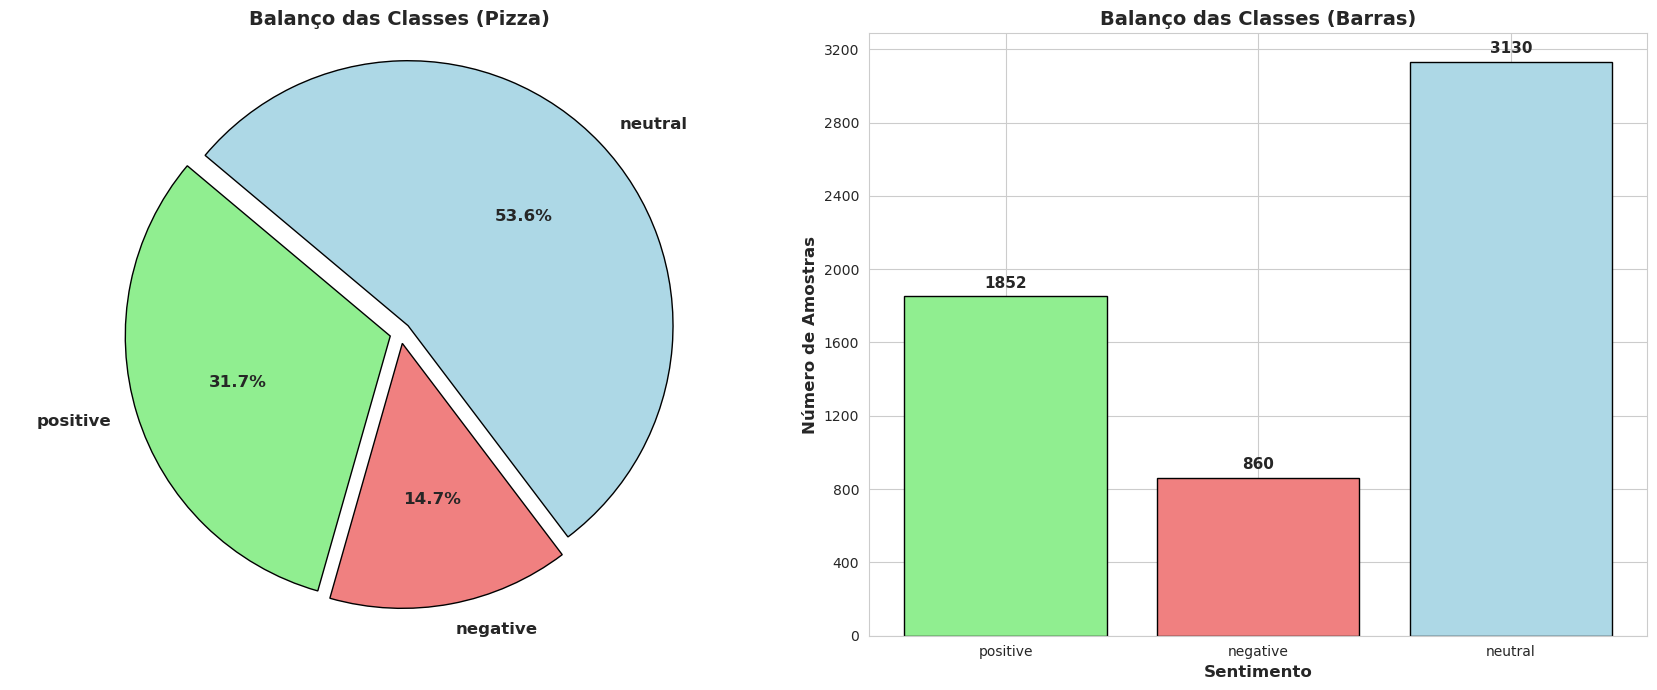

In [20]:
# Criar figura com dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

# Dados das classes gerais
unique_labels = dataset_df['Sentiment'].unique()
labels_classes = pd.Series(unique_labels).astype(str)

sizes_classes = dataset_df['Sentiment'].value_counts().reindex(labels_classes, fill_value=0)
explode_classes = tuple([0.04] * len(labels_classes))

# --- Definição do Mapa de Cores ---
color_map = {
    'positive': 'lightgreen',
    'negative': 'lightcoral',
    'neutral': 'lightblue'
}

ordered_colors = [color_map.get(label, 'grey') for label in labels_classes]


# --- Gráfico de Pizza (à esquerda) ---
text_props_pizza = {'fontsize': 12, 'weight': 'bold'}

wedges, texts, autotexts = ax1.pie(sizes_classes, labels=labels_classes, autopct='%1.1f%%',
                                   startangle=140, explode=explode_classes,
                                   colors=ordered_colors, # Aplicar cores personalizadas
                                   wedgeprops={'edgecolor': 'black'},
                                   textprops=text_props_pizza)
ax1.set_title("Balanço das Classes (Pizza)", fontsize=14, fontweight='bold')
ax1.axis('equal')

# --- Gráfico de Barras (à direita) ---
bars = ax2.bar(labels_classes, sizes_classes,
               color=ordered_colors, # Aplicar as mesmas cores personalizadas
               edgecolor='black')

# Adicionar valores em cima das barras (sem a porcentagem)
for bar_item, label in zip(bars, labels_classes): # Usar bar_item para evitar conflito com a variável bars
    height = bar_item.get_height()
    ax2.text(bar_item.get_x() + bar_item.get_width()/2., height + 0.01 * max(sizes_classes, default=1),
             f'{int(height)}',
             ha='center', va='bottom',
             fontsize=text_props_pizza['fontsize'] - 1,
             fontweight=text_props_pizza['weight'])

# Personalização do gráfico de barras com fontes coordenadas
ax2.set_title("Balanço das Classes (Barras)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Sentimento", fontsize=text_props_pizza['fontsize'], fontweight=text_props_pizza['weight'])
ax2.set_ylabel("Número de Amostras", fontsize=text_props_pizza['fontsize'], fontweight=text_props_pizza['weight'])

if all(isinstance(size, (int, float)) and size == int(size) for size in sizes_classes):
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
else:
    plt.setp(ax2.get_xticklabels(), fontsize=text_props_pizza['fontsize']-1, rotation=0, ha="center")

plt.tight_layout()
plt.show()


Nota-se que o tamanho do texto, a contagem de palavras e o comprimento médio das palavras não apresentam variação nas distribuições, apenas variando a contagem de classes. Dessa froam não é possível determinar a relevância desses atributos para a classificação de sentimentos.

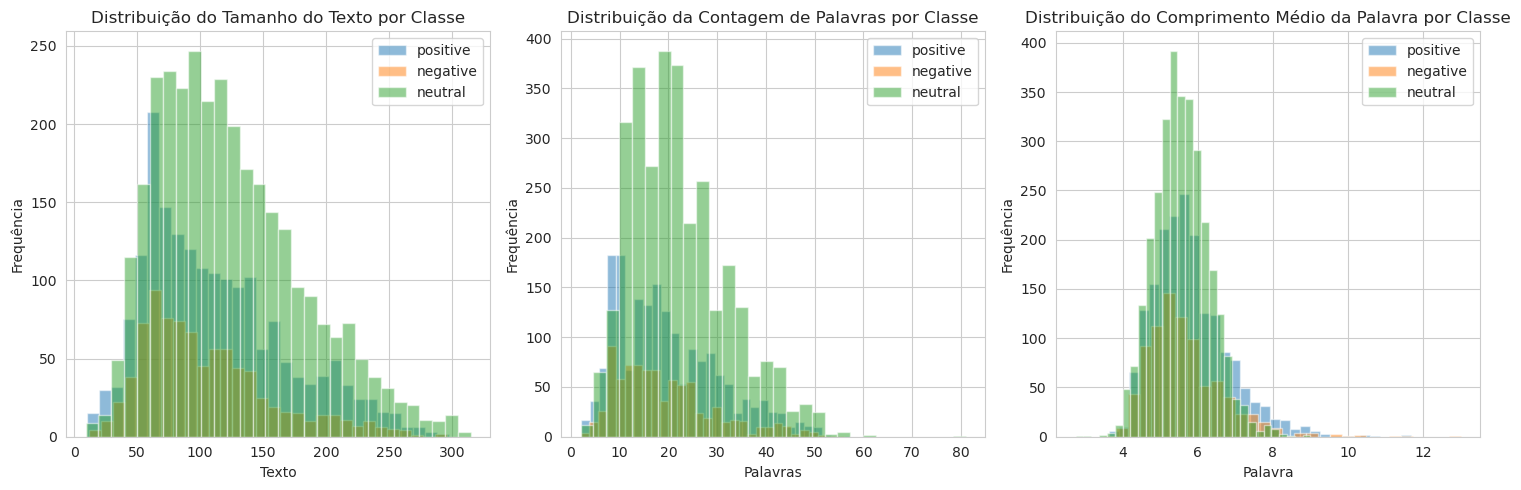

In [21]:
# Definir configurações do plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['text_length', 'word_count', 'avg_word_length']
titles = ['Distribuição do Tamanho do Texto',
          'Distribuição da Contagem de Palavras',
          'Distribuição do Comprimento Médio da Palavra']
sentiments = ['positive', 'negative', 'neutral']

# Criar os três histogramas
for ax, feature, title in zip(axes, features, titles):
    for sentiment in sentiments:
        ax.hist(dataset_df[dataset_df['Sentiment'] == sentiment][feature],
                bins=30, alpha=0.5, label=sentiment)
    ax.set_title(f'{title} por Classe')
    ax.set_xlabel(title.split()[-1])
    ax.set_ylabel('Frequência')
    ax.legend()

plt.tight_layout()
plt.show()


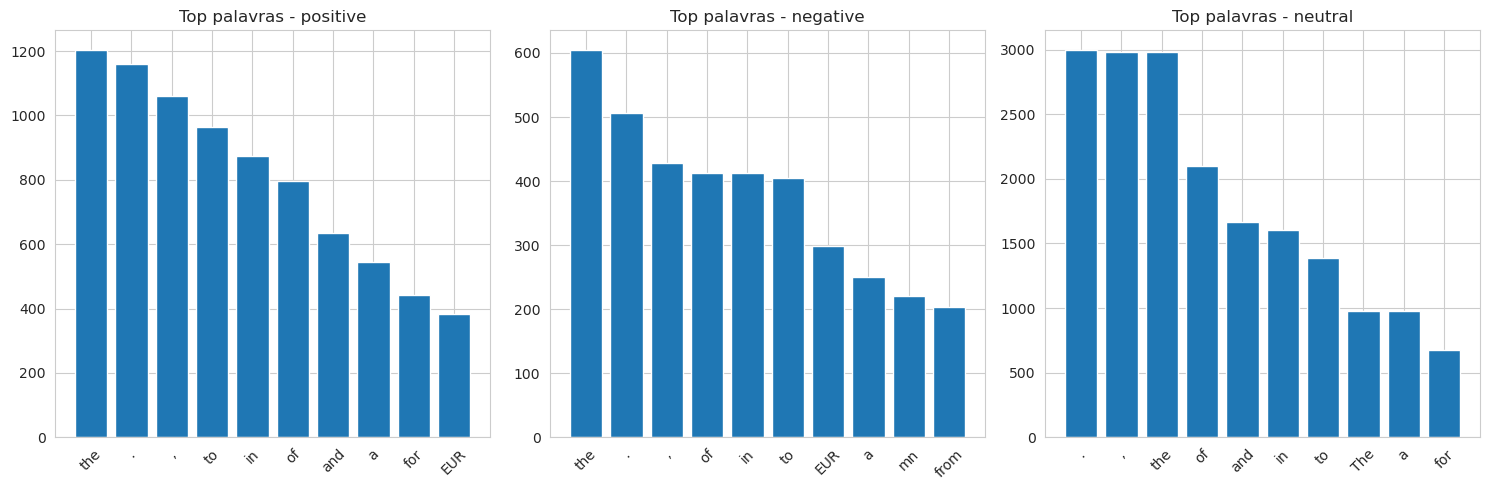

In [22]:
# Análise de frequência de palavras
def get_top_words(texts, n=10):
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

# Criar visualização para palavras mais frequentes por sentimento
plt.figure(figsize=(15, 5))
for i, sentiment in enumerate(['positive', 'negative', 'neutral']):
    texts = dataset_df[dataset_df['Sentiment'] == sentiment]['Sentence']
    top_words = get_top_words(texts)

    plt.subplot(1, 3, i+1)
    words, counts = zip(*top_words)
    plt.bar(words, counts)
    plt.title(f'Top palavras - {sentiment}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos verificar se existe alguma relação entre tamanho do texto, contagem de exclamações, interrogações e palavras em caixa alta com o sentimento do texto. Para isso, iremos criar algumas características básicas do texto original, como o tamanho do texto, a contagem de exclamações e interrogações, e a contagem de palavras em caixa alta.

Outras características serão extraídas do dicionário Loughran-McDonald, que contém palavras associadas a sentimentos financeiros. Essas características incluem contagens de palavras positivas, negativas, de incerteza, litigiosas e constrangedoras.

Em seguida aplicaremos visualizações e teste de hipótese Kruskal-Wallis para analisar a distribuição dessas características em relação aos sentimentos. Isso nos ajudará a identificar padrões e relações entre as características do texto e os sentimentos expressos.

INICIANDO ANÁLISE DE SENTIMENTOS FINANCEIROS
Dicionário LM carregado: ../data/Loughran-McDonald_MasterDictionary_1993-2024.csv
  Positive: 347 palavras
  Negative: 2345 palavras
  Uncertainty: 297 palavras
  Litigious: 903 palavras
  Strong_Modal: 19 palavras
  Weak_Modal: 27 palavras
  Constraining: 184 palavras

Criando features...

Balanceando dataset...
Dataset balanceado: 2580 amostras (860 por classe)

Distribuição das classes:
Sentiment
neutral     860
negative    860
positive    860
Name: count, dtype: int64

Testando significância estatística...
Testando 12 features (alpha=0.05)

Feature: text_length
  Kruskal-Wallis: H=38.252, p=0.0000 - Significativo

Feature: word_count
  Kruskal-Wallis: H=10.265, p=0.0059 - Significativo

Feature: avg_word_length
  Kruskal-Wallis: H=18.377, p=0.0001 - Significativo

Feature: exclamation_count
  Kruskal-Wallis: H=17.623, p=0.0001 - Significativo

Feature: question_count
  Kruskal-Wallis: H=11.115, p=0.0039 - Significativo

Feature: uppercas

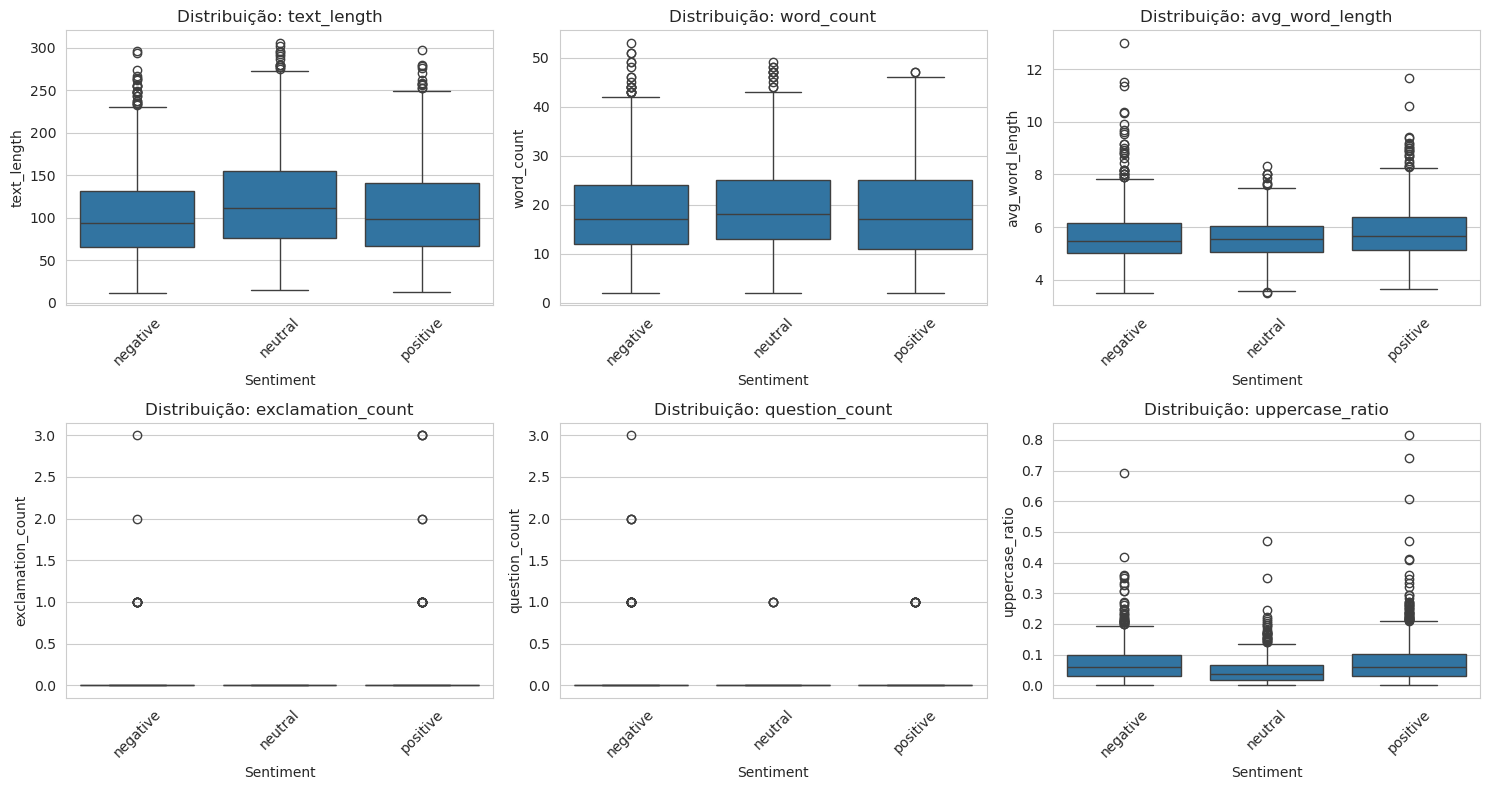


Primeiras linhas com features:


,Sentence,Sentiment,text_length,word_count,avg_word_length,exclamation_count,question_count,uppercase_ratio,lm_positive,lm_negative,lm_uncertainty,lm_litigious
0,"Ruukki 's delivery includes steel structures ,...",neutral,144,19,6.545455,0,0,0.013889,0,0,0,0
1,Operating profit excluding non-recurring items...,negative,97,17,6.466667,0,0,0.072165,0,0,0,0
2,The parties have agreed not to disclose the tr...,neutral,63,10,5.727273,0,0,0.015873,0,1,0,0
3,"Paper companies were in negative territories ,...",neutral,178,40,5.085714,0,0,0.056180,0,1,0,0
4,Added. Cost now at 1.54. Bounce off of Put OI ...,positive,129,29,4.607143,0,0,0.124031,0,0,0,0


In [23]:
# Configurar o caminho do dicionário LM
LM_FILE_PATH = "../data/Loughran-McDonald_MasterDictionary_1993-2024.csv"

# Executar análise
df_processed, test_results = run_sentiment_analysis(
    df=dataset_df,  # Seu DataFrame original
    lm_file_path=LM_FILE_PATH,
    use_balanced=True  # Mude para False se não quiser balancear
)

# Ver primeiras linhas com features
feature_cols = [col for col in df_processed.columns if col not in ['Sentence', 'Sentiment']]
print("\nPrimeiras linhas com features:")
display(df_processed[['Sentence', 'Sentiment'] + feature_cols[:10]].head())


Notamos então que algumas das features criadas a partir do dicionário Loughran-McDonald (LM) e as características básicas do texto apresentam diferenças significativas entre os sentimentos.

### Análise do Score de cada Palavra com TF-IDF.

É importante também analisar o score de cada palavra, na frase, em relação ao sentimento, para entender quais palavras são mais relevantes para cada classe. Para isso, utilizaremos a técnica TF-IDF (Term Frequency-Inverse Document Frequency), que mede a importância de uma palavra em um documento em relação a um corpus de documentos.

In [24]:


tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset_df['Sentence'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores_array = X_tfidf.toarray() # Renomeado de tfidf_scores para evitar conflito com o DataFrame
tfidf_df = pd.DataFrame(tfidf_scores_array, columns=feature_names)

# Calcular a média dos scores TF-IDF para cada palavra em cada classe
for sentiment in dataset_df['Sentiment'].unique():
    sentiment_mask = dataset_df['Sentiment'] == sentiment
    mean_scores = tfidf_scores_array[sentiment_mask].mean(axis=0)
    print(f"\n--- Média dos scores TF-IDF para a classe '{sentiment}' ---")

    # Exibir as 10 palavras com maior score médio
    top_indices = np.argsort(mean_scores)[-10:][::-1]  # Índices das 10 palavras com maior score
    top_words = [(feature_names[i], mean_scores[i]) for i in top_indices]
    for word, score in top_words:
        print(f"Palavra: '{word}', Score: {score:.4f}")




--- Média dos scores TF-IDF para a classe 'positive' ---
Palavra: 'eur', Score: 0.0396
Palavra: 'mn', Score: 0.0277
Palavra: 'sales', Score: 0.0238
Palavra: 'year', Score: 0.0227
Palavra: 'profit', Score: 0.0208
Palavra: 'net', Score: 0.0194
Palavra: 'company', Score: 0.0172
Palavra: 'said', Score: 0.0165
Palavra: 'million', Score: 0.0163
Palavra: 'http', Score: 0.0159

--- Média dos scores TF-IDF para a classe 'negative' ---
Palavra: 'eur', Score: 0.0609
Palavra: 'mn', Score: 0.0547
Palavra: 'profit', Score: 0.0338
Palavra: 'sales', Score: 0.0259
Palavra: 'operating', Score: 0.0241
Palavra: 'year', Score: 0.0233
Palavra: 'quarter', Score: 0.0205
Palavra: 'net', Score: 0.0204
Palavra: 'loss', Score: 0.0199
Palavra: 'period', Score: 0.0196

--- Média dos scores TF-IDF para a classe 'neutral' ---
Palavra: 'eur', Score: 0.0307
Palavra: 'company', Score: 0.0279
Palavra: 'mn', Score: 0.0190
Palavra: 'million', Score: 0.0168
Palavra: 'finland', Score: 0.0154
Palavra: 'sales', Score: 0.0153


Notamos que muitas das palavras se repetem, no entanto, algumas palavras são relevantes para cada grupo como "profit" e "million" para positivo, "loss" para negativo. Essas palavras podem ser indicativas de sentimentos financeiros específicos.

### Random Forest para análise da Importância de cada Palavra e Atributo

Para ter certeza da importância de cada palavra e atributo, utilizaremos o modelo Random Forest, que é um modelo de aprendizado de máquina baseado em árvores de decisão. Ele é capaz de lidar com dados complexos e não lineares, além de fornecer uma medida de importância para cada feature.

Tomaremos essa medida para ter certeza que estamos adicionando features relevantes para o modelo, e assim, melhorar a acurácia do modelo.

In [25]:
numerical_features = dataset_df[[col for col in dataset_df.columns if col not in ['Sentence', 'Sentiment']]]
X_combined = np.hstack((X_tfidf.toarray(), numerical_features))

# Treinar o modelo Random Forest
kfold = KFold(n_splits=5, shuffle=True)
splits = kfold.split(X_combined)

importances = np.array([])
for (train_index, test_index) in splits:
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = dataset_df['Sentiment'].iloc[train_index], dataset_df['Sentiment'].iloc[test_index]

    # Treinar o modelo Random Forest
    rf_model = RandomForestClassifier(n_jobs=-1)
    rf_model.fit(X_train, y_train)

    importances = np.hstack((importances, rf_model.feature_importances_))


# Calcular a média das importâncias
importance_mean = np.mean(importances.reshape(-1, X_train.shape[1]), axis=0)
importance_std = np.std(importances.reshape(-1, X_train.shape[1]), axis=0)

numerical_features_names = numerical_features.columns.values
feature_names = np.concatenate([feature_names, numerical_features_names])

# Criar um DataFrame com as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_mean})
# Ordenar as importâncias
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Exibir as 10 palavras mais importantes
top_importances = importance_df.head(10)
print("\n--- 10 Features/Palavras mais Importantes ---")
for index, row in top_importances.iterrows():
    print(f"Palavra: '{row['Feature']}', Importância: {row['Importance']:.4f}")



--- 10 Features/Palavras mais Importantes ---
Palavra: 'avg_word_length', Importância: 0.0335
Palavra: 'text_length', Importância: 0.0289
Palavra: 'word_count', Importância: 0.0287
Palavra: 'rose', Importância: 0.0108
Palavra: 'increased', Importância: 0.0091
Palavra: 'year', Importância: 0.0086
Palavra: 'eur', Importância: 0.0085
Palavra: 'profit', Importância: 0.0084
Palavra: 'https', Importância: 0.0081
Palavra: 'sales', Importância: 0.0073


## Pré-processamento

Segundo a importância das features, grande parte das features construídas apresentam importância significativa, logo, serão mantidas. Além disso, faremos o pré-processamento do texto, removendo stopwords, convertendo as palavras para seu lema, convertendo para minúsculas, a fim de simplificar o modelo, contendo apenas informação de quantas palavras em caixa alta estavam presente.

Dentre os caracteres especiais, iremos remover todos, exceto interrogações e exclamações, pois apesar de não serem estritamente relevantes a maioria dos textos que tem sentimento positivo ou negativo, possuem uma maior quantidade desses caracteres. Assim, podemos considerar que eles podem carregar alguma informação relevante.

Dessa forma, precisaremos extrair informações da sentença de forma mais granular, ou seja, palavra por palavra. Para isso, utilizaremos o TF-IDF (Term Frequency-Inverse Document Frequency), que é uma técnica de transformação de texto em vetores numéricos, onde cada palavra é representada por um número que indica sua importância no texto.

In [26]:
df_processed, test_results = run_sentiment_analysis(
    df=dataset_df,  # Seu DataFrame original
    lm_file_path=LM_FILE_PATH,
    use_balanced=False,  # Mude para False se não quiser balancear
    print_plot=False  # Desativar plotagens para pré-processamento
)


Dicionário LM carregado: ../data/Loughran-McDonald_MasterDictionary_1993-2024.csv
  Positive: 347 palavras
  Negative: 2345 palavras
  Uncertainty: 297 palavras
  Litigious: 903 palavras
  Strong_Modal: 19 palavras
  Weak_Modal: 27 palavras
  Constraining: 184 palavras

Criando features...

Usando dataset original: 5842 amostras

Distribuição das classes:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Testando significância estatística...
Testando 12 features (alpha=0.05)

Feature: text_length
  Kruskal-Wallis: H=98.386, p=0.0000 - Significativo

Feature: word_count
  Kruskal-Wallis: H=38.185, p=0.0000 - Significativo

Feature: avg_word_length
  Kruskal-Wallis: H=38.859, p=0.0000 - Significativo

Feature: exclamation_count
  Kruskal-Wallis: H=44.736, p=0.0000 - Significativo

Feature: question_count
  Kruskal-Wallis: H=25.719, p=0.0000 - Significativo

Feature: uppercase_ratio
  Kruskal-Wallis: H=348.114, p=0.0000 - Significativo

Feature: lm_po

In [27]:
# Remover alfanuméricos
dataset_df['Sentence'] = dataset_df['Sentence'].str.replace(r'\d+', '')

# Deixar tudo em minúsculo
dataset_df['Sentence'] = dataset_df['Sentence'].str.lower()

# Remover pontuação, exceto exclamações e interrogações.
dataset_df['Sentence'] = dataset_df['Sentence'].str.replace(r'[^\w\s!?]', '', regex=True)


# Remover stopwords (Ex: "the", "is", "in", "and")
stopwords = nltk.corpus.stopwords.words('english')
dataset_df['Sentence'] = dataset_df['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

# Leamatização (reduzir palavras à sua raiz)
lemmatizer = WordNetLemmatizer()
dataset_df['Sentence'] = dataset_df['Sentence'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

In [28]:
# 1. Primeiro fazer o train_test_split nos índices
train_idx, test_idx = train_test_split(
    dataset_df.index,
    test_size=0.2,
    random_state=42
)

# 2. Separar os dados de treino e teste usando os índices
X_train_text = dataset_df.loc[train_idx, 'Sentence']
X_test_text = dataset_df.loc[test_idx, 'Sentence']


X_train_num = dataset_df.loc[train_idx, numerical_features_names]
X_test_num = dataset_df.loc[test_idx, numerical_features_names]

# 3. Aplicar TF-IDF apenas no texto
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# 4. Combinar TF-IDF com features numéricas
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_num))

# 4.1 Normalizar as features

scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)

X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_num))
X_test_combined = scaler.transform(X_test_combined)

y_train = dataset_df['Sentiment'].loc[train_idx]
y_test = dataset_df['Sentiment'].loc[test_idx]


# 6. Aplicar Label Encoder nos targets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Modelagem: Classificação de Sentimentos

Aqui, aplicaremos diferentes algoritmos de aprendizado de máquina para classificar os sentimentos dos textos. Avaliaremos o desempenho de cada modelo com base no F1-score, devido o desbalanceamento dos dados.

In [29]:
# Opções de Teste
NUM_FOLDS = 10
SEED = 19
SCORING = 'f1_macro'


In [30]:
models = [
    ('Dummy', DummyClassifier(strategy='most_frequent', random_state=SEED)),
    ('LR', LogisticRegression(max_iter=1000, random_state=SEED)),
    ('GNB', GaussianNB()),
    ("LDA", LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=SEED)),
    ('SVM', SVC(random_state=SEED)),
    ('NN', MLPClassifier(max_iter=400, random_state=SEED)),
    ('RF', RandomForestClassifier(random_state=SEED))
    ]

In [31]:

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=NUM_FOLDS)
    cv_results = cross_val_score(model, X_train_combined, y_train, cv=kfold, scoring=SCORING)

    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



Dummy: 0.233 (0.006902)
LR: 0.494 (0.019229)
GNB: 0.431 (0.023880)
LDA: 0.511 (0.021459)
KNN: 0.340 (0.021533)
CART: 0.459 (0.020495)
SVM: 0.496 (0.021714)
NN: 0.525 (0.023315)
RF: 0.515 (0.009767)


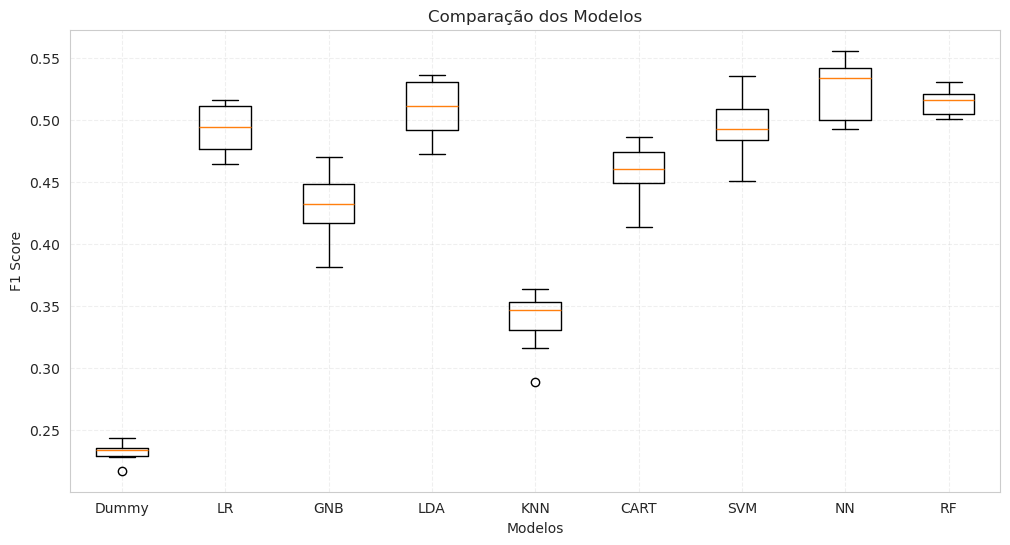

In [32]:
# compare algorithms
plt.figure(figsize=(12, 6))
plt.boxplot(results)
plt.xticks(range(1, len(names) + 1), names)
plt.title('Comparação dos Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1 Score')
plt.grid(axis='both', linestyle='--', alpha=0.3)
plt.show()

Os modelos se desempenharam mal, na totalidade, no entanto, o modelo Random Forest se destacou, apresentando um desempenho superior, apesar de seu desvio padrão significativo. Segundo a literatura, modelos como RF desempenham bem em dados tabulares e bem definidos, como os atributos mais significativos da base.

Logo, testaremos o modelo RF com os dados de teste, para verificar se ele se comporta bem.

In [33]:
modelo_RF = RandomForestClassifier()
modelo_RF.fit(X_train_combined, y_train)

# Testar o modelo com os dados de teste

y_pred = modelo_RF.predict(X_test_combined)
# Calcular as métricas de desempenho
classification_report_result = classification_report(y_test, y_pred, output_dict=True)

print("Desempenho do Modelo de Regressão Logística nos Dados de Teste:")
print(f"Accuracy: {classification_report_result['accuracy']:.3f}")
print(f"Recall: {classification_report_result['weighted avg']['recall']:.3f}")
print(f"Precision: {classification_report_result['weighted avg']['precision']:.3f}")
print(f"F1 Score: {classification_report_result['weighted avg']['f1-score']:.3f}")


Desempenho do Modelo de Regressão Logística nos Dados de Teste:
Accuracy: 0.660
Recall: 0.660
Precision: 0.633
F1 Score: 0.640


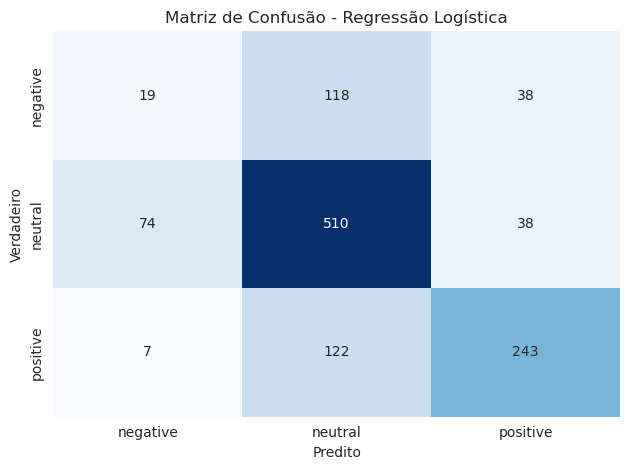

In [34]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=modelo_RF.classes_)
# Plotar a matriz de confusão com Seaborn
label_names = label_encoder.inverse_transform(modelo_RF.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

Nota-se que o modelo não apresenta um bom desempenho, confundindo classes de interesse ("Positive" e "Negative") com a classe "Neutral". Isso pode se dá pelo desbalanceamento dos dados, onde a classe "Neutral" é a mais frequente, aliado ao fato de que o modelo não consegue capturar bem as nuances dos sentimentos expressos nos textos, especialmente quando há uma mistura de sentimentos ou quando o texto é neutro.

Com isso, justifica-se o uso de modelos mais complexos, como Transformers, que são capazes de capturar melhor as relações contextuais entre palavras e entender melhor o significado dos textos. Além de aplicar sobre-amostragem para balancear as classes, o que pode melhorar o desempenho do modelo. (Realizado no notebook FinantialSentiment_DeepModels.ipynb)